In [1]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

In [2]:
path_to_zip = tf.keras.utils.get_file('spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip', extract=True)

2654208/2638744 [==============================] - 0s 0us/step


In [3]:
path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

In [22]:
with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

print("Data Size: ", len(raw))
print("Example :")

for sen in raw[0:100][::20]: print(">>", sen)

Data Size:  118964
Example :
>> Go.	Ve.
>> Wait.	Esperen.
>> Hug me.	Abrázame.
>> No way!	¡Ni cagando!
>> Call me.	Llamame.


In [23]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    # 소문자 변경
    sentence = sentence.lower().strip()

    # 1. 문장 부호를 \1
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    # 2. [ ] --> 공백
    sentence = re.sub(r'[" "]+', " ", sentence)
    # 3. 모든 알파벳, 문장기호를 제외한 것들을 공백으로 바꿔주세요.
    sentence = re.sub(r"[^a-zA-Z?!.,]+", " ", sentence)

    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'

    return sentence 

In [24]:
enc_corpus = []
dec_corpus = []

num_examples = 30000

for pair in raw[:num_examples]:
    eng, spa = pair.split("\t")

    enc_corpus.append(preprocess_sentence(eng))
    dec_corpus.append(preprocess_sentence(spa, s_token=True, e_token=True))

print("English :", enc_corpus[100])
print("Spanish :", dec_corpus[100])

English : go away !
Spanish : <start> salga de aqu ! <end>


In [25]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)
    
    tensor = tokenizer.texts_to_sequences(corpus)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [26]:
# 정제된 텍스트를 tokenize()함수를 사용해 토큰화해서 텐서로 변환하기!
enc_tensor, enc_tokenizer = tokenize(enc_corpus)
dec_tensor, dec_tokenizer = tokenize(dec_corpus)

In [27]:
# Quiz 1 훈련데이터와 검증데이터를 8:2 분리하세요.
enc_train, enc_val, dec_train, dec_val = train_test_split(enc_tensor, dec_tensor, test_size = 0.2)

In [28]:
# Quiz 2
# index_word를 활용하여 english vocab size 반환
# index_word를 활용하여 spanish vocab size 반환

print('English Vocab Size :', len(enc_tokenizer.index_word))
print('Spanish Vocab Size :', len(dec_tokenizer.index_word))

English Vocab Size : 4931
Spanish Vocab Size : 8893


- Bahdanau Attention
$$ Score_{alignment} = W * tanh(W_{decoder} * H_{decoder} + W_{encoder} * H_{encoder}) $$

In [29]:
# 바다나우 어텐션 클래스 만들기
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape : [batch x length x units]
        # h_dec shape : [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))

        attn = tf.nn.softmax(score, axis = 1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)
        
        return context_vec, attn

In [30]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        # todo
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units, return_sequences=True)

    def call(self, x):
        # todo
        out = self.embedding(x)
        out = self.gru(out)

        return out

In [31]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        # todo
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units, return_sequences=True, return_state= True)
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        # todo
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)

        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [32]:
BATCH_SIZE = 64
src_vocab_size = len(enc_tokenizer.index_word)+1
tgt_vocab_size = len(dec_tokenizer.index_word)+1

units = 1024
embedding_dim = 512

encoder = Encoder(src_vocab_size, embedding_dim, units)
decoder = Decoder(tgt_vocab_size, embedding_dim, units)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print('Encoder Output :', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))
sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)), sample_state, sample_output)

print('Decoder output :', sample_logits.shape)
print('Decoder Hidden State :', h_dec.shape)
print('Attention :', attn.shape)

Encoder Output : (64, 30, 1024)
Decoder output : (64, 8894)
Decoder Hidden State : (64, 1024)
Attention : (64, 30, 1)


In [37]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
# Categorical Crossentropy()
# [0.1 0.2 0.7] ----> one hot encoding [0, 0, 1]
# SparseCategoricalCrossentropy
# [0.1 0.2 0.7] ----> 정수 인덱스 2

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)

    mask = tf.cast(mask, dtype = loss.dtype)
    loss *= mask

    return tf.reduce_mean(loss)

# Train_step
train step 학습과정
1. Encoder에 소스 문장을 전달해 컨텍스트 벡터인 enc_out을 생성
2. Decoder에 입력으로 전달할 토큰 문장 생성
3. t=0일 때, Decoder의 Hidden state는 Encoder의 Final state로 정의. h_dec = enc_out[:, -1]
4. 문장과 enc_out, Hidden state를 기반으로 다음단어 (t=1)예측 pred
5. 예측된 단어와 정답간의 loss을 구한 후, t=1의 정답 단어를 다음 입력으로 사용 (예측단어X)
6. 반복!

In [38]:
@tf.function
def train_step(src, tgt, encoder, decoder, opimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]

        dec_src = tf.expand_dims([dec_tok.word_index['<start>']]*bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)
            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)

    batch_loss = (loss/int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [39]:
!pip install tqdm

In [ ]:
from tqdm import tqdm
import random

epochs = 20

for epoch in range(epochs):
    total_loss = 0
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
        total_loss += batch_loss

t.set_description_str('Epoch %2d' % (epoch+1))
t.set_postfix_str('Loss %.4f' % (total_loss.numpy()/(batch+1)))

##Evaluate step

In [71]:
@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
  bsz = src.shape[0]
  loss = 0

  enc_out = encoder(src)
  h_dec = enc_out[:, -1]

  dec_src = tf.expand_dims([dec_tok.word_index['<start>']]*bsz, 1)

  for t in range(1, tgt.shape[1]):
    pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)
    loss += loss_function(tgt[:, t], pred)
    dec_src = tf.expand_dims(tgt[:,t], 1)

  batch_loss = (loss/int(tgt.shape[1]))

  return batch_loss

In [72]:
# Training Process
from tqdm import tqdm

EPOCHS = 10

for epoch in range(EPOCHS):
  total_loss = 0

  idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
  random.shuffle(idx_list)
  t = tqdm(idx_list)

  for (batch, idx) in enumerate(t):
    batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                            dec_train[idx:idx+BATCH_SIZE],
                            encoder,
                            decoder,
                            optimizer,
                            dec_tokenizer)
    total_loss += batch_loss

    t.set_description_str('Epoch %2d' % (epoch +1))
    t.set_postfix_str('Loss %.4f' % (total_loss.numpy()/ (batch+1)))

  test_loss = 0

  idx_list = list(range(0, enc_val.shape[0], BATCH_SIZE))
  random.shuffle(idx_list)
  t = tqdm(idx_list)

  for (test_batch, idx) in enumerate(t):
    test_batch_loss = eval_step(enc_val[idx:idx+BATCH_SIZE],
                                dec_val[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                dec_tokenizer)
    test_loss += test_batch_loss

    t.set_description_str('Test Epoch %2d' % (epoch+1))
    t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy()/ (test_batch+1)))

Test Epoch 10: 100%|██████████| 94/94 [00:10<00:00,  9.29it/s, Test Loss 0.8509]


In [73]:
def evaluate(sentence, encoder, decoder):
  attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
  sentence = preprocess_sentence(sentence)
  inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
  inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                         maxlen = enc_train.shape[-1],
                                                         padding= 'post')
  
  result = ''
  enc_out = encoder(inputs)
  dec_hidden = enc_out[:, -1]
  dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

  for t in range(dec_train.shape[-1]):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)
    
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention[t] = attention_weights.numpy()

    predicted_id = \
    tf.argmax(tf.math.softmax(predictions, axis = -1)[0]).numpy()

    result += dec_tokenizer.index_word[predicted_id] + ' '

    if dec_tokenizer.index_word[predicted_id] == '<end>':
      return result, sentence, attention
    
    dec_input = tf.expand_dims([predicted_id], 0)
  return result, sentence, attention

In [75]:
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict = fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [76]:
def translate(sentence, encoder, decoder):
  result, sentence, attention = evaluate(sentence, encoder, decoder)

  print('Input : %s' % (sentence))
  print('Predicted translation : {}'.format(result))

  attention = attention[:len(result.split()), :len(sentence.split())]
  plot_attention(attention, sentence.split(), result.split(' '))
  

Input : can i have some coffee ?
Predicted translation : puedo tomar algo de hacer ? <end> 


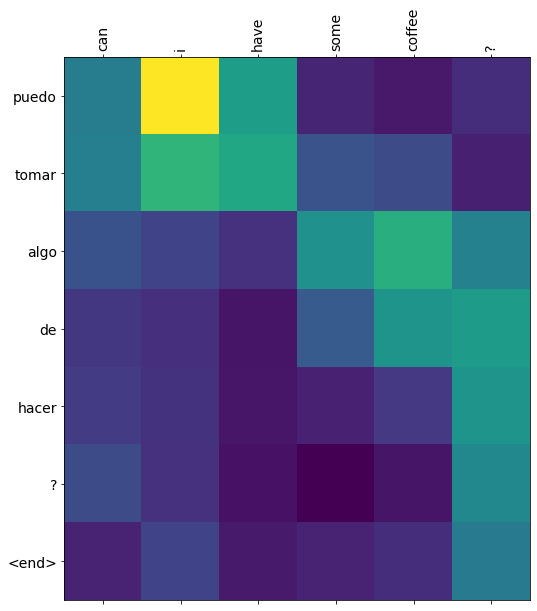

In [77]:
translate("Can I have some coffee?",encoder, decoder)

In [70]:
dec_tokenizer.word_index['sos']

119

## Transformer
기존의 seq2seq 모델의 한계
- 입력 시퀀스를 하나의 벡터표현으로 압축 (context vector) 디코더는 이를 통해 출력 시퀀스를 만들어냄
- 정보가 일부 손실된다는 단점

---
- $d_{model}$ = 512
- num_layers = 6
- num_heads = 8
- $d_{ff}$ = 2048

### 포지셔널 인코딩

$$PE_(pose, 2i) = sin(pos/1000^{2i/d_{model}})$$
$$PE_(pose, 2i+1) = cos(pos/1000^{2i/d_{model}})$$

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [5]:
class PositionalEncoding(tf.keras.layers.Layer):
  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스(2i)에는 사인 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])

    # 배열의 홀수 인덱스(2i+1)에는 코사인 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    angle_rads = np.zeros(angle_rads.shape)
    angle_rads[:, 0::2] = sines
    angle_rads[:, 1::2] = cosines
    pos_encoding = tf.constant(angle_rads)
    pos_encoding = pos_encoding[tf.newaxis, ...]

    print(pos_encoding.shape)
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

(1, 50, 128)


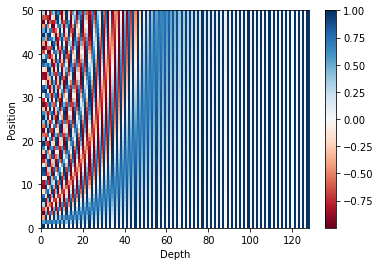

In [6]:
# 50x 128크기를 가지는 포지셔널 인코딩 행렬을 시각화하기
# 입력문자의 단어가 50 각 단어가 128차원의 임베딩 벡터를 가질 때 사용하는 행렬

sample_pos_encoding = PositionalEncoding(50, 128)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap = "RdBu")
plt.xlabel('Depth')
plt.xlim((0, 128))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [7]:
def scaled_dot_product_attention(query, key, value, mask):
    # query 크기 : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    # key 크기 : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
    # value 크기 : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
    # padding mask : (batch_size, 1, 1, key의 문장 길이)

    # Q와 K의 곱
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 스케일링 : dk의 루트값으로 나눈다.
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk /tf.math.sqrt(depth)

    # 마스킹 어텐션 스코어 행렬의 마스킹 할 위치에 매우 작은 음수값을 넣는다.
    # 매우 작은 값이므로 소프트맥스 함수를 지나면 행렬의 해당 위치의 값은 0이 된다.
    if mask is not None:
        logits += (mask * -1e9)

    # 소프트맥스 함수는 마지막 차원인 key의 문장 길이 방향으로 수행된다.
    # attention weight : (batch_size, num_heads, query의 문장 길이, key의 문장 길이)
    attention_weight = tf.nn.softmax(logits, axis=-1)

    # output : (batch_size, num_heads, query의 문장 길이 , d_model/num_heads)
    output = tf.matmul(attention_weight, value)

    return output, attention_weight

In [8]:
# scaled_dot_product_attention함수가 정상적으로 작동하는지 테스트 !
np.set_printoptions(suppress=True)
temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                     [0, 0, 10],
                     [0, 0, 10]], dtype=tf.float32) # (4, 3)
temp_v = tf.constant([[  1, 0],
                     [  10, 0],
                     [ 100, 5],
                     [1000, 6]], dtype=tf.float32) # (4, 2)
temp_q = tf.constant([[0, 10, 0]], dtype = tf.float32) # (1, 3)

In [9]:
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_attn) # 어텐션 분포
print(temp_out) # 어텐션 값

tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [11]:
# scaled_dot_product_attention함수가 정상적으로 작동하는지 테스트 !
np.set_printoptions(suppress=True)
temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                     [0, 0, 10],
                     [0, 0, 10]], dtype=tf.float32) # (4, 3)
temp_v = tf.constant([[  1, 0],
                     [  10, 0],
                     [ 100, 5],
                     [1000, 6]], dtype=tf.float32) # (4, 2)
temp_q = tf.constant([[0, 0, 10]], dtype = tf.float32) # (1, 3)

In [12]:
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_attn) # 어텐션 분포
print(temp_out) # 어텐션 값

tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [13]:
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_attn) # 어텐션 분포
print(temp_out) # 어텐션 값

tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [14]:
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_attn) # 어텐션 분포
print(temp_out) # 어텐션 값

tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


### 멀티헤드 어텐션

병렬 어텐션의 효과?  
머리가 여러개이기 때문에, 여러 시점에서 상대방을 볼 수 있다.

1. $W_Q, W_k, W_v$에 해당하는 $d_{model}$크기의 밀집층(Dense layer)을 지남
2. 지정된 헤드 수 (num_heads)만큼 나눈다.
3. 스케일드 닷 프로덕트 어텐션
4. 나눠졌던 헤드들을 연결한다.
5. W_0에 해당하는 밀집층을 지나게 된다.

In [16]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0
        
        self.depth = d_model //  self.num_heads
        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense  = tf.keras.layers.Dense(units = d_model)
        self.value_dense = tf.keras.layers.Dense(units = d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth)
        )
        return tf.transpose(inputs, perm=[0,2,1,3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]
        # 1. Wq, wk, wv에 해당하는 밀집층 지나기
        # q : (batch_size, query의 문장 길이, d_model)
        # k : (batch_size, key의 문장 길이, d_model)
        # v : (batch_size, value의 문장 길이, d_model)

        # 참고 ** 인코더 (k, v)- 디코터(q) 어텐션에서는 query길이와 key, value의 길이는 다를 수 있다.
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 2. 헤드 나누기
        # q : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
        # k : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
        # v : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 3. 스케일 닷 프로덕트 어텐션
        # (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
        scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
        # (batch_size, query의 문장 길이, num_heads, d_model/num_heads)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 4. 헤드 연결
        # (batch_size, query의 문장 길이, d_model)
        concat_attention = tf.reshape(scaled_dot_product_attention, (batch_size, -1, self.d_model))

        # 5. wo에 해당하는 dence층 지나기
        # (batch_size, query의 문장 길이, d_model)
        outputs = self.dense(concat_attention)

        return outputs


### 패딩 마스크

In [17]:
def create_padding_mask(x):
   mask = tf.cast(tf.math.equal(x, 0), tf.float32)
   # (batch_size, 1, 1, key의 문장 길이)
   return mask[:, tf.newaxis, tf.newaxis, :]

In [18]:
print(create_padding_mask(tf.constant([[1, 21, 777, 0, 0]])))

tf.Tensor([[[[0. 0. 0. 1. 1.]]]], shape=(1, 1, 1, 5), dtype=float32)


# 포지션 와이드 피드 포워드 신경망

```python
outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
outpus = tf.kears.layers.Dense(units=d_model)(outpus)
```

### 잔차 연결과 층 정규화
![](https://wikidocs.net/images/page/31379/transformer22.PNG)

### 인코더 구현하기

In [19]:
def encoder_layer(dff, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 인코더는 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1,1,None), name="padding_mask")

    # 멀티-헤드 어텐션(첫 번째 서브층 / 셀프 어텐션)
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
            'query': inputs,
            'key' : inputs,
            'value' : inputs, # Q = K = V
            'mask' : padding_mask
        })

    # 드롭아웃 + 잔차 연결과 층 정규화
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNomalization(
        epsilon=1e-6)(inputs+attention)

    # 포지션 와이즈 피드 포워드 신경망 (두 번째 서브층)
    outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 드롭아웃 + 잔차 연결과 층 정규화
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention+outputs)

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [ ]:
def encoder(vocab_size num_layers, dff, d_model, num_heads, dropout,name='encoder'):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 인코더는 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1,1,None), name="padding_mask")

    # 포지셔널 인코딩 + 드롭아웃
    embeddings = tf.keras.layers.Embedding(vocab_size,, d_model)(inputs)
    embeddings = tf.keras.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # 인코더를 num_layers개 쌓기
    for i in range(num_layers):
        outputs = encoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)